### Notebook: Preparing Time Independent Models

31 May 2024

Objectives:
- Further work on cross-validation
- Analysis and visuals
- Deal with age issue


## 0. Setup

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error, auc

# ------------------------------------------------
from catboost import CatBoostClassifier, Pool, cv #, MetricVisualizer
from catboost.utils import get_roc_curve

# ------------------------------------------------

data_path = "../../main_data/locale_specific_data/"
fig_path  = '../../images/time_independent_figures/'


In [2]:
dog_df = pd.read_csv(data_path + "Sonoma_time_independent_data_akry.csv")
print(len(dog_df))

dog_df=dog_df[dog_df.intake_age>=0].reset_index(drop=True)
print(len(dog_df))

dog_df.head()

6505
6499


,breed,color,sex,size,date_of_birth,animal_id,intake_date,outcome_date,days_in_shelter,intake_type,...,outcome_adopt,outcome_adopt_subtype,intake_age,outcome_age,pop_control,sex_bin,size_bin,breed_pit,color_mix,intake_bin
0,PIT BULL,GRAY/WHITE,Female,MED,2012-09-03,A296009,2013-08-22,2014-04-14,235,TRANSFER,...,False,none,0.97,1.61,1,1,3,1,1,4
1,PIT BULL,BLUE/WHITE,Female,MED,2012-10-09,A294143,2013-08-31,2014-04-14,226,STRAY,...,False,none,0.89,1.51,1,1,3,1,1,0
2,CAROLINA DOG/MIX,GOLD/WHITE,Male,MED,2007-09-07,A281788,2013-09-19,2014-07-30,314,STRAY,...,False,none,6.03,6.90,0,0,3,0,1,0
3,CHIHUAHUA SH,TAN,Male,TOY,2007-10-01,A297574,2013-10-01,2014-01-01,92,OWNER SURRENDER,...,False,none,6.00,6.25,1,0,1,0,0,1
4,PIT BULL,TAN/WHITE,Male,MED,2012-10-29,A298002,2013-10-08,2014-05-22,226,STRAY,...,True,realtime,0.95,1.57,1,0,3,1,1,0


In [73]:
dog_df['breed_pure'] = 1*(dog_df.breed.str.contains('/')==False)
dog_df.breed_pure.sum()

3112

<Axes: xlabel='intake_age', ylabel='days_in_shelter'>

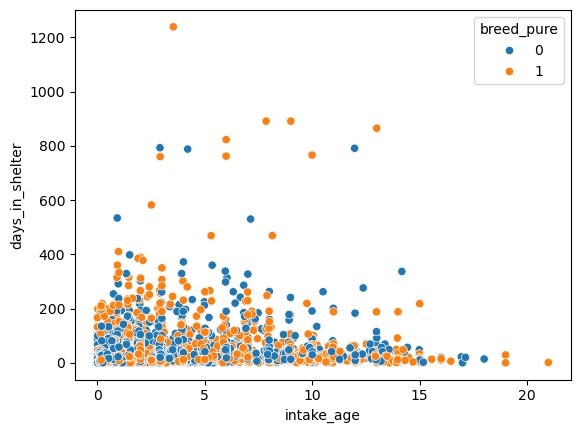

In [77]:
sns.scatterplot(data=dog_df, y='days_in_shelter',x='intake_age',hue='breed_pure')

In [80]:
dog_df[dog_df.breed.str.contains('/')==False].breed.unique()


array(['PIT BULL', 'CHIHUAHUA SH', 'TOY FOX TERRIER', 'PARSON RUSS TER',
       'GERM SHEPHERD', 'AUST KELPIE', 'MASTIFF', 'PLOTT HOUND',
       'LABRADOR RETR', 'BOXER', 'ANATOL SHEPHERD', 'ROTTWEILER',
       'BORDER COLLIE', 'MIN PINSCHER', 'POMERANIAN', 'LHASA APSO',
       'DOBERMAN PINSCH', 'AMERICAN STAFF', 'PRESA CANARIO', 'PEKINGESE',
       'AUST SHEPHERD', 'POODLE TOY', 'BICHON FRISE', 'CHIHUAHUA LH',
       'AUST CATTLE DOG', 'BOSTON TERRIER', 'POODLE MIN',
       'YORKSHIRE TERR', 'SHIH TZU', 'AKITA', 'RAT TERRIER', 'PUG',
       'DACHSHUND', 'AKBASH', 'SIBERIAN HUSKY', 'DACHSHUND WH',
       'SCHNAUZER MIN', 'GOLDEN RETR', 'BULLMASTIFF', 'SCOT TERRIER',
       'AMER BULLDOG', 'SPANISH MASTIFF', 'FOX TERR SMOOTH', 'SHIBA INU',
       'GERM SH POINT', 'GREAT PYRENEES', 'SHETLD SHEEPDOG', 'MALTESE',
       'DACHSHUND LH', 'CHINESE SHARPEI', 'BEAGLE', 'AMER ESKIMO',
       'CAIRN TERRIER', 'GREAT DANE', 'QUEENSLAND HEEL', 'WEST HIGHLAND',
       'BORDER COLLIE X', 'AUST TERRI

## 1. Deal with Ages

## 2. Working with the model

### Create train-test split 

In [37]:
feature_list = [ 'sex', 'size', 'breed', 'color',
                'days_in_shelter', 'outcome_season',
                'intake_age','intake_condition','intake_type']#,'outcome_adopt_subtype']

In [38]:
X_train, X_hold, y_train, y_hold = train_test_split(dog_df[feature_list],
                                      dog_df.outcome_adopt,
                                      shuffle=True,
                                      stratify=dog_df.outcome_adopt,
                                      test_size=0.2,
                                      random_state=1342)

In [39]:
tree_depth = 6
lrn_rate   = 0.1

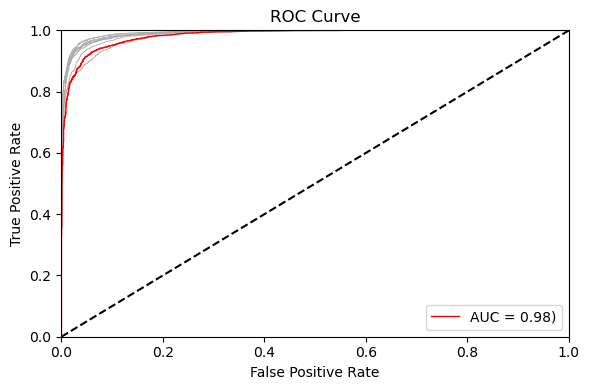

<Figure size 640x480 with 0 Axes>

In [40]:
cv_splits  = 9
kfold  = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=1342)

plt.figure(figsize=(6,4), layout="tight")

i = 0
for t_idx, h_idx in kfold.split(dog_df, dog_df.outcome_adopt):
      X_t = dog_df[feature_list].iloc[t_idx]
      X_t = X_t.astype(str)
      y_t = dog_df.outcome_adopt.iloc[t_idx]
      X_h = dog_df[feature_list].iloc[h_idx]
      X_h = X_h.astype(str)
      y_h = dog_df.outcome_adopt.iloc[h_idx]
      
      pool = Pool(X_t, y_t, cat_features=feature_list, feature_names=feature_list)

      clf  = CatBoostClassifier(iterations=1000, learning_rate=lrn_rate, loss_function="Logloss", depth=tree_depth).fit(pool, eval_set=(X_t, y_t), verbose=False)
      ## ROC curve - get data from catboost, plot with plt
      (fpr, tpr, thresholds) = get_roc_curve(clf, pool, plot=False)
      roc_auc = auc(fpr, tpr)
      plt.plot(fpr, tpr, c="darkgray", linewidth=0.50)#, label='CV {x} (AUC = {y})'.format(x=i+1, y=(round(roc_auc,2))))
      
      #print('Model params (CV {cv}): '.format(cv=str(i+1)))
      #print(clf.get_params())
      #confusion = confusion_matrix(y_true = y_t, y_pred = clf.predict(X_t))
      #print('Confusion Matrix:\n', confusion)
      #print(clf.get_feature_importance(data=pool, prettified=True, verbose=True))
      #print()
      #print("Classification Report:")
      #print(classification_report(y_true=y_t, y_pred=clf.predict(X_t)))
      i+=1
      del X_t, y_t, pool, clf, fpr, tpr, thresholds, roc_auc#, confusion

X_t = X_train.astype(str)
pool = Pool(X_t, y_train, cat_features=feature_list, feature_names=feature_list)
clf  = CatBoostClassifier(iterations=1000, learning_rate=lrn_rate, loss_function="Logloss", depth=tree_depth).fit(pool, eval_set=(X_t, y_train), verbose=False)
## ROC curve - get data from catboost, plot with plt
(fpr, tpr, thresholds) = get_roc_curve(clf, pool, plot=False)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, c="red", linewidth=1.0, label='AUC = {y})'.format(y=(round(roc_auc,2))))
del X_t, pool, clf, fpr, tpr, thresholds, roc_auc

plt.plot([0, 1], [0, 1], 'k--') #line y=x
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()
plt.clf()

#plt.savefig(roc_j)
#del feat, model_name, feature_list, tree_depth, lrn_rate, X_t, y_t, pool, clf, confusion, 



removed  outcome_season
removed  intake_type
removed  intake_condition


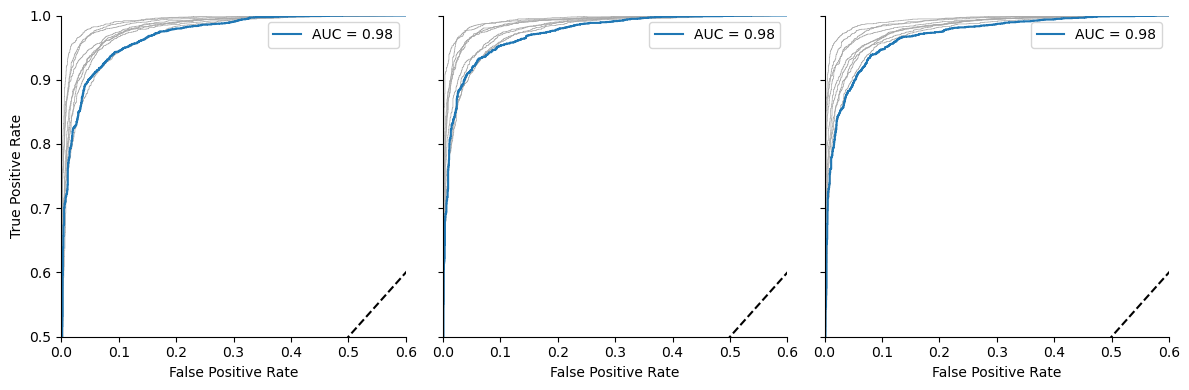

<Figure size 640x480 with 0 Axes>

In [49]:
rem_feat = ['outcome_season','intake_type','intake_condition']

fig, axes = plt.subplots(nrows=1, ncols=len(rem_feat), figsize=(4*len(rem_feat),4), sharey=True, layout="tight")

for i in range(len(rem_feat)):
    mod_feature_list = feature_list.copy()
    mod_feature_list.remove(rem_feat[i])
    print("removed ", rem_feat[i])

    cv_splits  = 9
    kfold  = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=1342)
    j = 0
    for t_idx, h_idx in kfold.split(dog_df, dog_df.outcome_adopt):
        X_t = dog_df[mod_feature_list].iloc[t_idx]
        X_t = X_t.astype(str)
        y_t = dog_df.outcome_adopt.iloc[t_idx]
        X_h = dog_df[mod_feature_list].iloc[h_idx]
        X_h = X_h.astype(str)
        y_h = dog_df.outcome_adopt.iloc[h_idx]
        
        pool = Pool(X_t, y_t, cat_features=mod_feature_list, feature_names=mod_feature_list)
        clf  = CatBoostClassifier(iterations=1000, learning_rate=lrn_rate, loss_function="Logloss", depth=tree_depth).fit(pool, eval_set=(X_t, y_t), verbose=False)
        (fpr, tpr, thresholds) = get_roc_curve(clf, pool, plot=False)
        
        axes[i].plot(fpr, tpr, c="darkgray", linewidth=0.50)

        j+=1
        del X_t, y_t, pool, clf, fpr, tpr, thresholds
    del cv_splits, kfold, j

    X_train_mod = X_train[mod_feature_list]
    X_train_mod = X_train_mod.astype(str)
    y_train_mod = y_train.copy()

    pool = Pool(X_train_mod, y_train_mod, cat_features=mod_feature_list, feature_names=mod_feature_list)
    clf  = CatBoostClassifier(iterations=1000, learning_rate=lrn_rate, loss_function="Logloss", depth=tree_depth)
    clf.fit(pool, eval_set=(X_train_mod, y_train_mod), verbose=False, plot=False)
    
    (fpr, tpr, thresholds) = get_roc_curve(clf, pool, plot=False)
    roc_auc = auc(fpr, tpr)
    
    axes[i].plot(fpr, tpr, label='AUC = {y}'.format(y=(round(roc_auc,2))))
    axes[i].plot([0, 1], [0, 1], 'k--')
    axes[i].legend(loc='best')
    axes[i].set_xlim(0.0, 0.6)
    axes[i].set_ylim(0.5, 1.0)
    axes[i].spines[['top','right']].set_visible(False)

    axes[i].set_xlabel('False Positive Rate')
    if i == 0:
        axes[i].set_ylabel('True Positive Rate')

    del mod_feature_list, X_train_mod, y_train_mod, pool, clf, fpr, tpr, thresholds, roc_auc
    i+=1

plt.show()
plt.clf()


#### Using only one feature

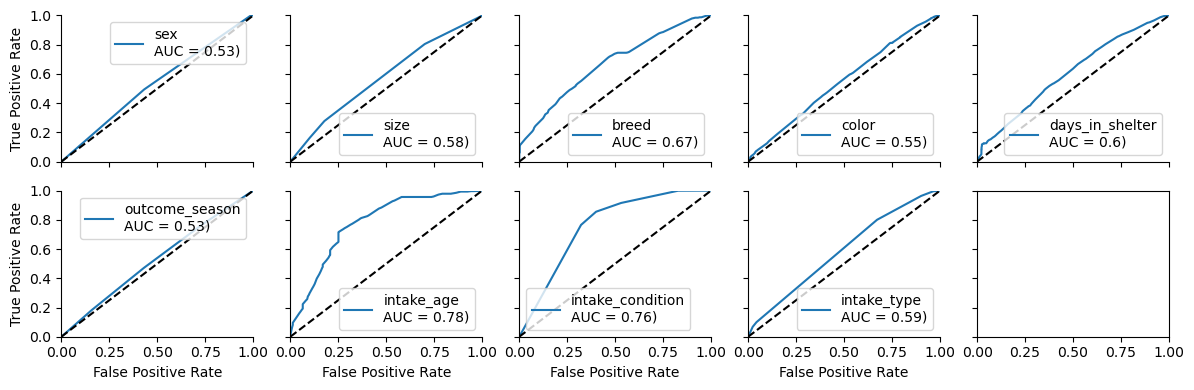

<Figure size 640x480 with 0 Axes>

In [50]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12,4), sharex=True,sharey=True, layout="tight")

i=0
for FEATURE in feature_list:
    
    X_t = X_train[FEATURE]
    X_t = X_t.astype(str)
    y_t = y_train
    pool = Pool(X_t, y_t, cat_features=[FEATURE], feature_names=[FEATURE])
    clf  = CatBoostClassifier(iterations=1000, learning_rate=lrn_rate, loss_function="Logloss", depth=tree_depth)
    clf.fit(pool, eval_set=(X_t, y_t), verbose=False, plot=False)
    
    (fpr, tpr, thresholds) = get_roc_curve(clf, pool, plot=False)
    roc_auc = auc(fpr, tpr)
    if i < 5:
        k = i
        j = 0
    else:
        k = i-5
        j = 1
    
    axes[j,k].plot(fpr, tpr, label='{x}\nAUC = {y})'.format(x=FEATURE, y=(round(roc_auc,2))))
    axes[j,k].plot([0, 1], [0, 1], 'k--')
    axes[j,k].legend(loc='best')
    axes[j,k].set_xlim(0.0, 1.0)
    axes[j,k].set_ylim(0.0, 1.0)
    if j == 1:
        axes[j,k].set_xlabel('False Positive Rate')
    if k==0:
        axes[j,k].set_ylabel('True Positive Rate')
    axes[j,k].spines[['top','right']].set_visible(False)

    del j,k, X_t, y_t, pool, clf, fpr, tpr, thresholds, roc_auc
    i+=1

plt.show()
plt.clf()
del fig, axes, i, FEATURE


### Try: Feature Selection Tool

In [51]:
from catboost import CatBoostRegressor, EShapCalcType, EFeaturesSelectionAlgorithm

In [67]:
def select_features_syntetic_CLSF(algorithm: EFeaturesSelectionAlgorithm, steps: int = 1):
    print('Algorithm:', algorithm)
    model = CatBoostClassifier(iterations=1000, random_seed=1342)
    summary = model.select_features(
        train_pool,
        #eval_set=test_pool,
        features_for_select=list(range(train_pool.num_col())),     # we will select from all features
        num_features_to_select=5,  # we want to select exactly important features
        steps=steps,                                     # more steps - more accurate selection
        algorithm=algorithm,
        shap_calc_type=EShapCalcType.Regular,            # can be Approximate, Regular and Exact
        train_final_model=True,                          # to train model with selected features
        logging_level='Silent',
        plot=True
    )
    print('Selected features:', summary['selected_features_names'])
    return summary

def select_features_syntetic_RGSR(algorithm: EFeaturesSelectionAlgorithm, steps: int = 1):
    print('Algorithm:', algorithm)
    model = CatBoostRegressor(iterations=1000, random_seed=1342)
    summary = model.select_features(
        train_pool,
        #eval_set=test_pool,
        features_for_select=list(range(train_pool.num_col())),     # we will select from all features
        num_features_to_select=5,  # we want to select exactly important features
        steps=steps,                                     # more steps - more accurate selection
        algorithm=algorithm,
        shap_calc_type=EShapCalcType.Regular,            # can be Approximate, Regular and Exact
        train_final_model=True,                          # to train model with selected features
        logging_level='Silent',
        plot=True
    )
    print('Selected features:', summary['selected_features_names'])
    return summary

In [81]:
mod_feature_list = [ 'sex', 'size', 'breed_pure', 'color',
                'days_in_shelter', 'outcome_season',
                'intake_age','intake_condition','intake_type']

X_train, X_hold, y_train, y_hold = train_test_split(dog_df[mod_feature_list],
                                      dog_df.outcome_adopt,
                                      shuffle=True,
                                      stratify=dog_df.outcome_adopt,
                                      test_size=0.2,
                                      random_state=1342)

X_t = X_train.astype(str)
X_h = X_hold.astype(str)

train_pool = Pool(X_t, y_train, cat_features=mod_feature_list, feature_names=mod_feature_list)
test_pool  = Pool(X_h, y_hold, cat_features=mod_feature_list, feature_names=mod_feature_list)

synthetic_shap_summary = select_features_syntetic_CLSF(algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues, steps=4)


Algorithm: EFeaturesSelectionAlgorithm.RecursiveByShapValues


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Selected features: ['size', 'days_in_shelter', 'outcome_season', 'intake_age', 'intake_condition']


In [82]:
synthetic_shap_summary = select_features_syntetic_RGSR(algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues, steps=4)

Algorithm: EFeaturesSelectionAlgorithm.RecursiveByShapValues


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Selected features: ['size', 'days_in_shelter', 'intake_age', 'intake_condition', 'intake_type']


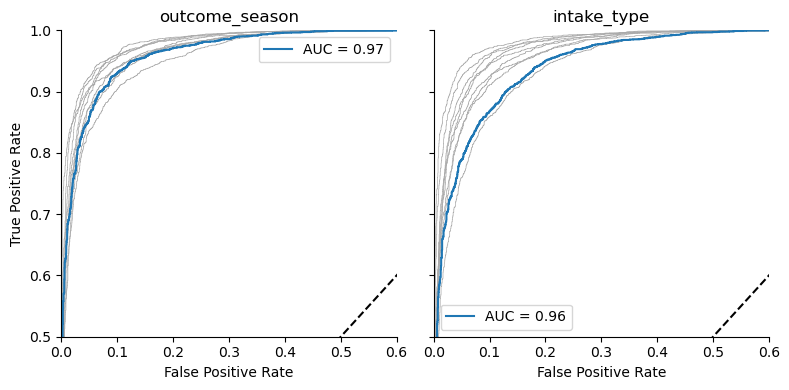

<Figure size 640x480 with 0 Axes>

In [84]:
firm_features = ['size', 'days_in_shelter', 'intake_age', 'intake_condition']

possible_features = ['outcome_season', 'intake_type']

fig, axes = plt.subplots(nrows=1, ncols=len(possible_features), figsize=(4*len(possible_features),4), sharey=True, layout="tight")

for i in range(len(possible_features)):
    mod_feature_list = firm_features + [possible_features[i]]

    cv_splits  = 9
    kfold  = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=1342)
    j = 0
    for t_idx, h_idx in kfold.split(dog_df, dog_df.outcome_adopt):
        X_t = dog_df[mod_feature_list].iloc[t_idx]
        X_t = X_t.astype(str)
        y_t = dog_df.outcome_adopt.iloc[t_idx]
        X_h = dog_df[mod_feature_list].iloc[h_idx]
        X_h = X_h.astype(str)
        y_h = dog_df.outcome_adopt.iloc[h_idx]
        
        pool = Pool(X_t, y_t, cat_features=mod_feature_list, feature_names=mod_feature_list)
        clf  = CatBoostClassifier(iterations=1000, learning_rate=lrn_rate, loss_function="Logloss", depth=tree_depth).fit(pool, eval_set=(X_t, y_t), verbose=False)
        (fpr, tpr, thresholds) = get_roc_curve(clf, pool, plot=False)
        
        axes[i].plot(fpr, tpr, c="darkgray", linewidth=0.50)

        j+=1
        del X_t, y_t, pool, clf, fpr, tpr, thresholds
    del cv_splits, kfold, j

    X_train_mod = X_train[mod_feature_list]
    X_train_mod = X_train_mod.astype(str)
    y_train_mod = y_train.copy()

    pool = Pool(X_train_mod, y_train_mod, cat_features=mod_feature_list, feature_names=mod_feature_list)
    clf  = CatBoostClassifier(iterations=1000, learning_rate=lrn_rate, loss_function="Logloss", depth=tree_depth)
    clf.fit(pool, eval_set=(X_train_mod, y_train_mod), verbose=False, plot=False)
    
    (fpr, tpr, thresholds) = get_roc_curve(clf, pool, plot=False)
    roc_auc = auc(fpr, tpr)
    
    axes[i].plot(fpr, tpr, label='AUC = {y}'.format(y=(round(roc_auc,2))))
    axes[i].plot([0, 1], [0, 1], 'k--')
    axes[i].legend(loc='best')
    axes[i].set_title(possible_features[i])
    axes[i].set_xlim(0.0, 0.6)
    axes[i].set_ylim(0.5, 1.0)
    axes[i].spines[['top','right']].set_visible(False)

    axes[i].set_xlabel('False Positive Rate')
    if i == 0:
        axes[i].set_ylabel('True Positive Rate')

    del mod_feature_list, X_train_mod, y_train_mod, pool, clf, fpr, tpr, thresholds, roc_auc
    i+=1

plt.show()
plt.clf()

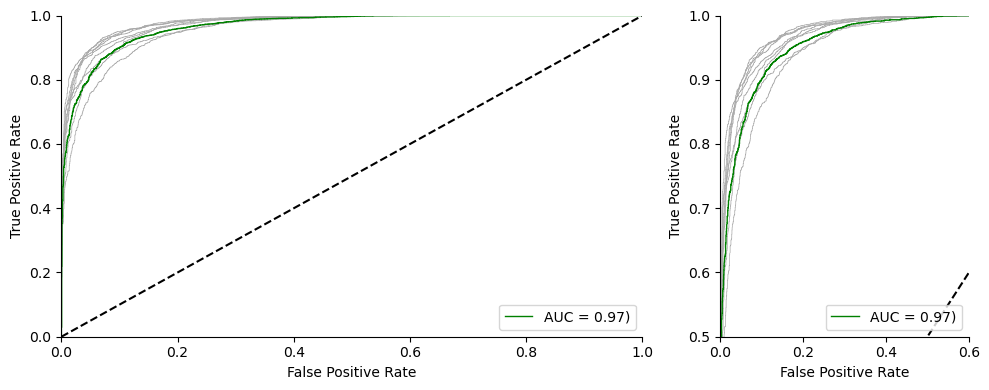

<Figure size 640x480 with 0 Axes>

In [90]:
final_feature_list = [ 'size', 'days_in_shelter', 'outcome_season','intake_age','intake_condition']

X_train, X_hold, y_train, y_hold = train_test_split(dog_df[final_feature_list],
                                      dog_df.outcome_adopt,
                                      shuffle=True,
                                      stratify=dog_df.outcome_adopt,
                                      test_size=0.2,
                                      random_state=1342)

cv_splits  = 9
kfold  = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=1342)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4), layout="tight", width_ratios=[0.7, 0.3])

i = 0
for t_idx, h_idx in kfold.split(X_train, y_train):
      X_t = X_train.iloc[t_idx]
      X_t = X_t.astype(str)
      y_t = y_train.iloc[t_idx]
      X_h = X_train.iloc[h_idx]
      X_h = X_h.astype(str)
      y_h = y_train.iloc[h_idx]
      
      pool = Pool(X_t, y_t, cat_features=final_feature_list, feature_names=final_feature_list)

      clf  = CatBoostClassifier(iterations=1000, learning_rate=lrn_rate, loss_function="Logloss", depth=tree_depth).fit(pool, eval_set=(X_t, y_t), verbose=False)
      ## ROC curve - get data from catboost, plot with plt
      (fpr, tpr, thresholds) = get_roc_curve(clf, pool, plot=False)
      roc_auc = auc(fpr, tpr)
      axes[0].plot(fpr, tpr, c="darkgray", linewidth=0.50)
      axes[1].plot(fpr, tpr, c="darkgray", linewidth=0.50)

      i+=1
      del X_t, y_t, pool, clf, fpr, tpr, thresholds, roc_auc


X_t = X_train.astype(str)
pool = Pool(X_t, y_train, cat_features=final_feature_list, feature_names=final_feature_list)
clf  = CatBoostClassifier(iterations=1000, learning_rate=lrn_rate, loss_function="Logloss", depth=tree_depth).fit(pool, eval_set=(X_t, y_train), verbose=False)
(fpr, tpr, thresholds) = get_roc_curve(clf, pool, plot=False)
roc_auc = auc(fpr, tpr)
axes[0].plot(fpr, tpr, c="green", linewidth=1.0, label='AUC = {y})'.format(y=(round(roc_auc,2))))
axes[1].plot(fpr, tpr, c="green", linewidth=1.0, label='AUC = {y})'.format(y=(round(roc_auc,2))))
del X_t, pool, clf, fpr, tpr, thresholds, roc_auc

axes[0].set_xlim(0.0, 1.0)
axes[0].set_ylim(0.0, 1.0)
axes[1].set_xlim(0.0, 0.6)
axes[1].set_ylim(0.5, 1.0)

for i in [0,1]:
    axes[i].plot([0, 1], [0, 1], 'k--') #line y=x
    axes[i].set_xlabel('False Positive Rate')
    axes[i].set_ylabel('True Positive Rate')
    axes[i].legend(loc="lower right")
    axes[i].spines[['top','right']].set_visible(False)
    
plt.show()
plt.clf()

#plt.savefig(roc_j)
#del feat, model_name, feature_list, tree_depth, lrn_rate, X_t, y_t, pool, clf, confusion, 

In [107]:
final_feature_list = [ 'size', 'days_in_shelter', 'outcome_season','intake_age','intake_condition']

plot_df = pd.DataFrame(columns=['iter', 'TN','FP','FN','TP','accuracy','predict_count','actual_count'])

i=1
while i <= 100:

    X_train, X_hold, y_train, y_hold = train_test_split(dog_df[final_feature_list],
                                        dog_df.outcome_adopt,
                                        shuffle=True,
                                        stratify=dog_df.outcome_adopt,
                                        test_size=0.2)
    
    X_train = X_train.astype(str)
    pool = Pool(X_train, y_train, cat_features=final_feature_list, feature_names=final_feature_list)

    clf  = CatBoostClassifier(iterations=1000, learning_rate=lrn_rate, loss_function="Logloss", depth=tree_depth).fit(pool, eval_set=(X_train, y_train), verbose=False)
    matrix = confusion_matrix(y_true = y_train, y_pred = clf.predict(X_train))

    plot_df.loc[i-1, 'iter']      = i
    plot_df.loc[i-1, 'TN'] =matrix[0,0]
    plot_df.loc[i-1, 'FP'] =matrix[0,1]
    plot_df.loc[i-1, 'FN'] =matrix[1,0]
    plot_df.loc[i-1, 'TP'] =matrix[1,1]

    plot_df.loc[i-1, 'accuracy']      = accuracy_score(y_true = y_train, y_pred = clf.predict(X_train))
    plot_df.loc[i-1, 'predict_count'] = np.sum(1*clf.predict(X_train)==True)
    plot_df.loc[i-1, 'actual_count']  = np.sum(1*(y_train==True))


    del X_train, X_hold, y_train, y_hold, pool, clf, matrix
    i+=1

del i


In [108]:
plot_df

,iter,TN,FP,FN,TP,accuracy,predict_count,actual_count
0,1,2033,299,145,2722,0.914599,3021,2867
1,2,2169,163,95,2772,0.950375,2935,2867
2,3,2062,270,105,2762,0.927871,3032,2867
3,4,1923,409,168,2699,0.889017,3108,2867
4,5,2158,174,135,2732,0.940565,2906,2867
...,...,...,...,...,...,...,...,...
95,96,2084,248,99,2768,0.933256,3016,2867
96,97,1915,417,181,2686,0.884978,3103,2867
97,98,2100,232,113,2754,0.933641,2986,2867
98,99,2073,259,104,2763,0.930179,3022,2867


In [114]:
final_feature_list = [ 'size', 'days_in_shelter', 'outcome_season','intake_age','intake_condition']

test_plot_df = pd.DataFrame(columns=['iter', 'TN','FP','FN','TP','accuracy','predict_count','actual_count'])

i=1
while i <= 100:
    print(i)
    X_train, X_hold, y_train, y_hold = train_test_split(dog_df[final_feature_list],
                                        dog_df.outcome_adopt,
                                        shuffle=True,
                                        stratify=dog_df.outcome_adopt,
                                        test_size=0.2)
    
    X_train = X_train.astype(str)
    X_hold  = X_hold.astype(str)
    pool = Pool(X_train, y_train, cat_features=final_feature_list, feature_names=final_feature_list)

    clf  = CatBoostClassifier(iterations=1000, learning_rate=lrn_rate, loss_function="Logloss", depth=tree_depth).fit(pool, eval_set=(X_train, y_train), verbose=False)
    
    matrix = confusion_matrix(y_true = y_hold, y_pred = clf.predict(X_hold))
    test_plot_df.loc[i-1, 'iter']      = i
    test_plot_df.loc[i-1, 'TN'] =matrix[0,0]
    test_plot_df.loc[i-1, 'FP'] =matrix[0,1]
    test_plot_df.loc[i-1, 'FN'] =matrix[1,0]
    test_plot_df.loc[i-1, 'TP'] =matrix[1,1]

    test_plot_df.loc[i-1, 'accuracy']      = accuracy_score(y_true = y_hold, y_pred = clf.predict(X_hold))
    test_plot_df.loc[i-1, 'predict_count'] = np.sum(1*clf.predict(X_hold)==True)
    test_plot_df.loc[i-1, 'actual_count']  = np.sum(1*(y_hold==True))


    del X_train, X_hold, y_train, y_hold, pool, clf, matrix
    i+=1

del i

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


In [ ]:
test_plot_df

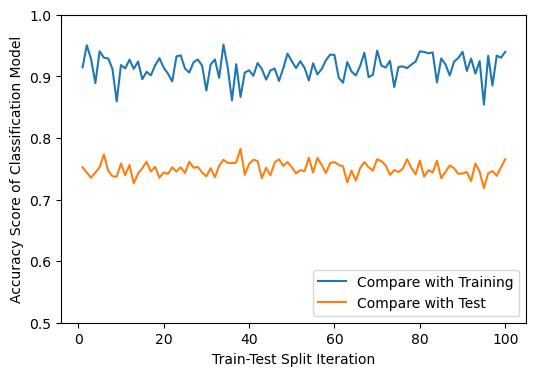

<Figure size 640x480 with 0 Axes>

In [123]:
fig = plt.figure(figsize=(6,4))

plt.plot(plot_df['iter'], plot_df["accuracy"], 
             label="Compare with Training")

plt.plot(test_plot_df['iter'], test_plot_df["accuracy"], 
label="Compare with Test")

plt.xlabel("Train-Test Split Iteration")
plt.ylabel("Accuracy Score of Classification Model")
plt.ylim([0.5, 1.00])
plt.legend(loc=4)

plt.show()
plt.clf()

In [120]:
plot_df.to_csv("final_model_against_training_data.csv")
test_plot_df.to_csv("final_model_against_test_data.csv")


In [121]:
test_plot_df

,iter,TN,FP,FN,TP,accuracy,predict_count,actual_count
0,1,365,218,104,613,0.752308,831,717
1,2,371,212,121,596,0.743846,808,717
2,3,360,223,121,596,0.735385,819,717
3,4,342,241,92,625,0.743846,866,717
4,5,379,204,118,599,0.752308,803,717
...,...,...,...,...,...,...,...,...
95,96,362,221,114,603,0.742308,824,717
96,97,355,228,102,615,0.746154,843,717
97,98,339,244,96,621,0.738462,865,717
98,99,366,217,105,612,0.752308,829,717
